In [1]:
# Importing the necessary packages
# Using keras with tensorflow in the background
import numpy as np 
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("All packages succesfully imported")

Using TensorFlow backend.


All packages succesfully imported


In [2]:
# Reading the path from the kaggle input of the data
path = os.path.join('..', 'input/skin-cancer-mnist-ham10000')
main_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(path, '*', '*.jpg'))}
# Defining the cancer types and adding it to the data in place of short names
cancer_type = {
    'nv': 'Melanocytic nevi','mel': 'Melanoma','bkl': 'Benign keratosis-like lesions ','bcc': 'Basal cell carcinoma','akiec': 'Actinic keratoses','vasc': 'Vascular lesions','df': 'Dermatofibroma'
}

In [3]:
# Reading the data from csv
# We add the path of the image which later on will be used to resize the image
# Also we add the full name for the cancer types and then we convert into categorical values which will be used for further modelling

cancer_data = pd.read_csv(os.path.join(path, 'HAM10000_metadata.csv'))
cancer_data['path'] = cancer_data['image_id'].map(main_path.get)
cancer_data['cancer_type'] = cancer_data['dx'].map(cancer_type.get) 
cancer_data['cancer_category'] = pd.Categorical(cancer_data['cancer_type']).codes
cancer_data.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cancer_type,cancer_category
6091,HAM_0004454,ISIC_0029834,nv,follow_up,25.0,male,trunk,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Melanocytic nevi,4
2752,HAM_0002744,ISIC_0031236,bcc,histo,45.0,female,upper extremity,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Basal cell carcinoma,1
2196,HAM_0003172,ISIC_0025832,mel,histo,65.0,male,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanoma,5


In [4]:
# Checking if any null values are present or not
cancer_data.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                57
sex                 0
localization        0
path                0
cancer_type         0
cancer_category     0
dtype: int64

In [5]:
# Since age column has 57 null values, we replace it with the mean value of the column. 
# Other methods to replace it are through median, min and max of the column values, but mean is the most appropriate

cancer_data['age'].fillna((cancer_data['age'].mean()), inplace=True)

In [6]:
# Checking if null values are filled or not ?

cancer_data.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
path               0
cancer_type        0
cancer_category    0
dtype: int64

In [7]:
# Loading and resizing the images into 96*96 which would be light for tensorflow to handle
# The main reason we resize to a smaller pixel density is reduce the load on the memory and the GPU.
# Bigger pixel size consume lots of memory and increase the consumption of GPU also, hence an ideal density of 96*96 pixels

cancer_data['image'] = cancer_data['path'].map(lambda x: np.asarray(Image.open(x).resize((96,96))))

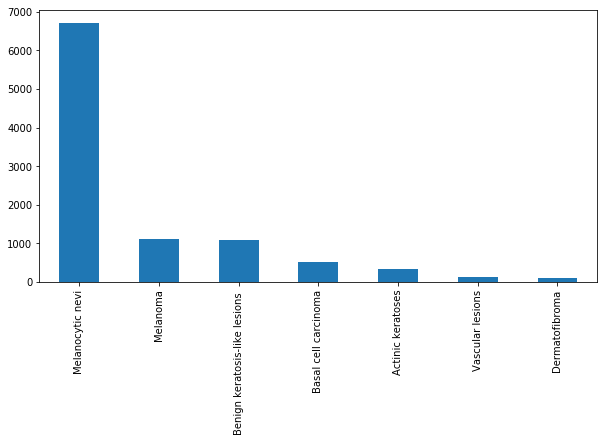

In [8]:
# Plot to see distribution of 7 different classes of cancer type
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
cancer_data['cancer_type'].value_counts().plot(kind='bar', ax=ax1)

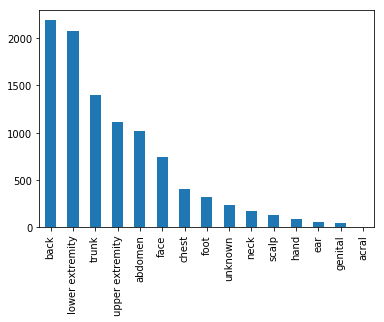

In [9]:
# Plot to see which body location is affected the most due to the cancer
cancer_data['localization'].value_counts().plot(kind='bar')

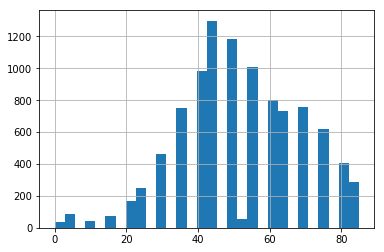

In [10]:
# Checking the distribution of age according to cancer affected 
cancer_data['age'].hist(bins=30)

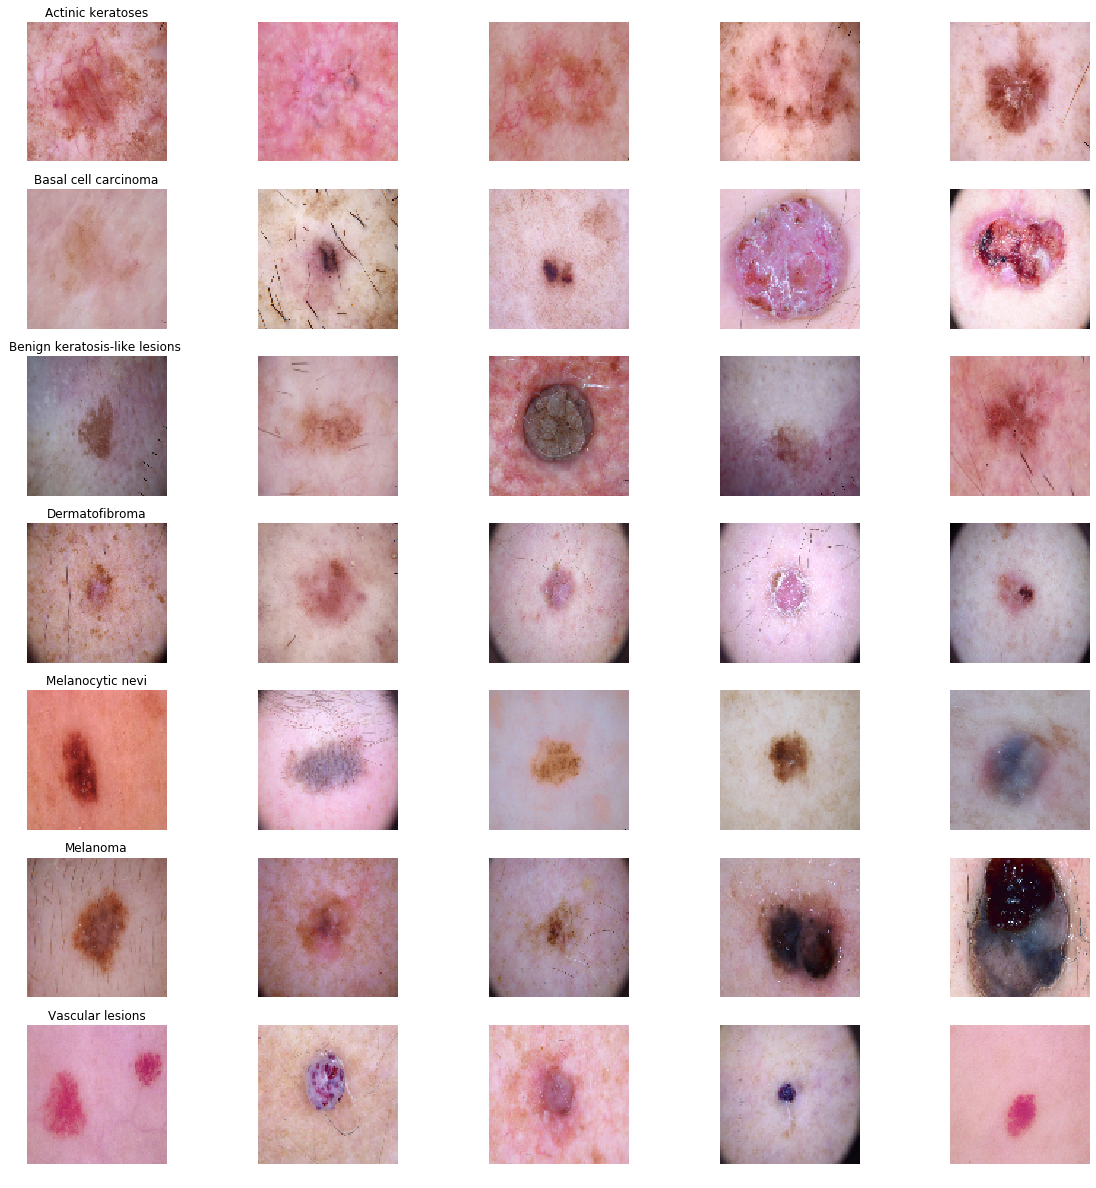

In [11]:
# Looking at sample images
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         cancer_data.sort_values(['cancer_type']).groupby('cancer_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [12]:
# Checking the image size distribution
cancer_data['image'].map(lambda x: x.shape).value_counts()

(96, 96, 3)    10015
Name: image, dtype: int64

In [13]:
# Splitting the data into 75:25 train,test ratio
features=cancer_data.drop(columns=['cancer_category'],axis=1)
target=cancer_data['cancer_category']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25,random_state=1234)

In [14]:
# To get the data values into common scale, we perform normalization
# To perform normalization we subtract their mean values from it and then dividing by their standard deviation.

x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [15]:
# We peroform label encoding for different cancer types since we trying to predict which type of cancer the image is
# So we perform one hot encoding where different categories are assigned numerical values
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [16]:
# After creating train test split, we create a validation set to validate our predications.
# Generally we create a small proportion of validation i.e. 10%
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [17]:
# Reshaping the train,test and validation data into 96*96 pixels
x_train = x_train.reshape(x_train.shape[0], *(96, 96, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 96, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 96, 3))

In [18]:
# Model building. Defining the convulution
input_shape = (96, 96, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='softmax', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='softmax', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Conv2D(256, 3, padding='same', activation='softmax'),
    MaxPooling2D(),
    Dropout(0.10),
    
    Flatten(),
    Dense(128, activation='softmax'),
    Dropout(0.55),
    
    Dense(7, activation='softmax')
])

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [22]:
#Data Augmentation** to avoiding the overfitting.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [23]:
# Fitting the model
epochs = 75 
batch_size = 10
history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Epoch 1/75
675/675 [==============================] - 27s 40ms/step - loss: 1.4428 - acc: 0.6642 - val_loss: 1.1965 - val_acc: 0.6742
Epoch 2/75
675/675 [==============================] - 22s 33ms/step - loss: 1.2056 - acc: 0.6717 - val_loss: 1.1427 - val_acc: 0.6742
Epoch 3/75
675/675 [==============================] - 23s 33ms/step - loss: 1.1689 - acc: 0.6702 - val_loss: 1.1312 - val_acc: 0.6742
Epoch 4/75
674/675 [============================>.] - ETA: 0s - loss: 1.1498 - acc: 0.6710
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
675/675 [==============================] - 21s 32ms/step - loss: 1.1494 - acc: 0.6712 - val_loss: 1.1295 - val_acc: 0.6742
Epoch 5/75
675/675 [==============================] - 22s 32ms/step - loss: 1.1457 - acc: 0.6699 - val_loss: 1.1287 - val_acc: 0.6742
Epoch 6/75
675/675 [==============================] - 22s 33ms/step - loss: 1.1349 - acc: 0.6725 - val_loss: 1.1285 - val_acc: 0.6742
Epoch 7/75
673/675 [================

In [24]:
# Evaluation of the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

752/752 [==============================] - 0s 328us/sample - loss: 1.1362 - acc: 0.6742
Validation: accuracy = 0.674202  ;  loss_v = 1.136168
Test: accuracy = 0.663738  ;  loss = 1.140243


In [25]:
# Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

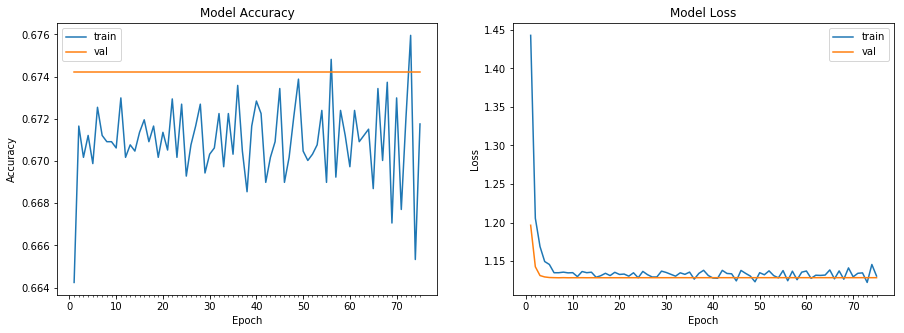

In [26]:
plot_model_history(history)

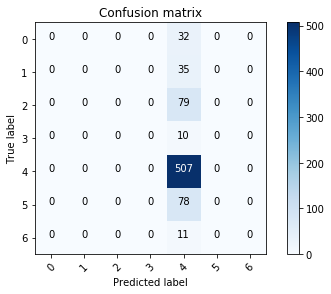

In [27]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))